In [2]:
import sys
import obspy
import time
sys.path.append("/home/niyiyu/Research/pnwstore/")

import pandas as pd
import numpy as np
import h5py 
import matplotlib.pyplot as plt
from tqdm import tqdm


from libcomcat.dataframes import get_phase_dataframe
from libcomcat.search import get_event_by_id

In [3]:
# be sure to check the location of waveforms and metadata

path_to_data = "../Extract/mpiextract/proc2007_"
# path_to_data = '/home/niyiyu/.seisbench/datasets/pnw/'
# path_to_data = './Extract/'

f = h5py.File(path_to_data + "waveforms.hdf5", "r")
df = pd.read_csv(path_to_data + "metadata.csv")
df.insert(0, "index", range(len(df)))
df['year'] = df.apply(lambda row: row.trace_start_time.split('-')[0], axis = 1)
df

,index,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,split,source_magnitude,station_network_code,...,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,year
0,0,uw10735803,2007-08-30T00:46:33.210000Z,47.801,-122.361,earthquake,21.041,dev,2.30,UW,...,NaN,0.0,0.0,0.0,"bucket9$0,:3,:15001",100,2007-08-30T00:45:43.210000Z,6606,5891,2007
1,1,uw10735803,2007-08-30T00:46:33.210000Z,47.801,-122.361,earthquake,21.041,train,2.30,PB,...,NaN,0.0,0.0,0.0,"bucket6$0,:3,:15001",100,2007-08-30T00:45:43.210000Z,7475,6396,2007
2,2,uw10735803,2007-08-30T00:46:33.210000Z,47.801,-122.361,earthquake,21.041,train,2.30,UW,...,NaN,0.0,0.0,0.0,"bucket1$0,:3,:15001",100,2007-08-30T00:45:43.210000Z,6828,6000,2007
3,3,uw10735088,2007-08-28T01:08:15.340000Z,47.416,-122.740,earthquake,50.604,train,2.33,TA,...,NaN,0.0,0.0,0.0,"bucket10$0,:3,:15001",100,2007-08-28T01:07:25.340000Z,6734,5939,2007
4,4,uw10735088,2007-08-28T01:08:15.340000Z,47.416,-122.740,earthquake,50.604,test,2.33,TA,...,NaN,0.0,0.0,0.0,"bucket4$0,:3,:15001",100,2007-08-28T01:07:25.340000Z,6676,5921,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5504,5504,uw10720898,2007-01-30T00:10:44.360000Z,47.352,-123.133,earthquake,19.841,train,0.40,TA,...,NaN,0.0,0.0,0.0,"bucket4$555,:3,:15001",100,2007-01-30T00:09:54.360000Z,6282,5729,2007
5505,5505,uw10720743,2007-01-29T13:44:57.750000Z,48.841,-123.437,earthquake,6.999,test,1.90,TA,...,NaN,0.0,0.0,0.0,"bucket8$557,:3,:15001",100,2007-01-29T13:44:07.750000Z,8295,6884,2007
5506,5506,uw10720743,2007-01-29T13:44:57.750000Z,48.841,-123.437,earthquake,6.999,train,1.90,PB,...,NaN,0.0,0.0,0.0,"bucket10$551,:3,:15001",100,2007-01-29T13:44:07.750000Z,7462,6374,2007
5507,5507,uw10720743,2007-01-29T13:44:57.750000Z,48.841,-123.437,earthquake,6.999,train,1.90,TA,...,NaN,0.0,0.0,0.0,"bucket4$556,:3,:15001",100,2007-01-29T13:44:07.750000Z,7468,6375,2007


In [6]:
snrs = []
d = []
for idx in tqdm(range(len(df))):
    ids = df.iloc[idx]['trace_S_arrival_sample']
    idp = df.iloc[idx]['trace_P_arrival_sample']
    tn = df.iloc[idx]['trace_name']
    bucket, narray = tn.split('$')
    x, y, z = iter([int(i) for i in narray.split(',:')])
    data = f['/data/%s' % bucket][x, :y, :z]

    for icha in range(3):
#         try:
        snr = 20 * np.log(np.percentile(np.abs(data[icha, ids:ids + 200]), 98)/
              np.percentile(np.abs(data[icha, :idp]), 98))/np.log(10)
        if not np.isnan(snr) and snr > -50:
            snrs.append(snr)
#         except:
#             pass

  0%|          | 0/5509 [00:00<?, ?it/s]/tmp/ipykernel_154492/1017750104.py:13: RuntimeWarning: invalid value encountered in double_scalars
  snr = 20 * np.log(np.percentile(np.abs(data[icha, ids:ids + 200]), 98)/
100%|██████████| 5509/5509 [00:07<00:00, 758.51it/s]


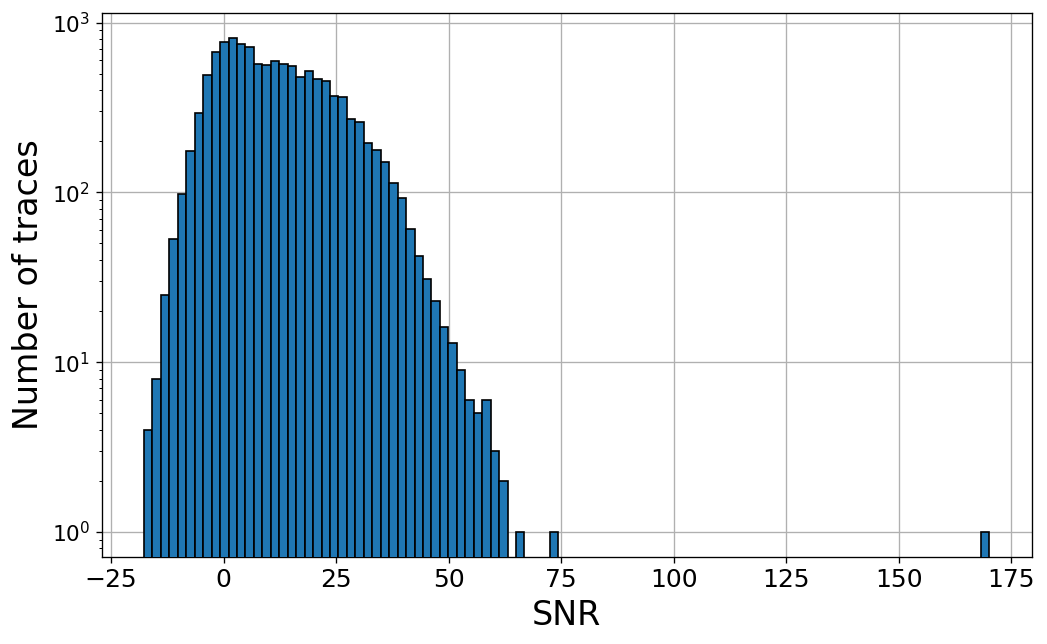

In [7]:
plt.figure(figsize = (10, 6), dpi = 120)
plt.hist(snrs, 100, zorder = 10, edgecolor = 'k')
plt.grid(True)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.xlabel("SNR", fontsize = 20)
plt.ylabel("Number of traces", fontsize = 20)
plt.gca().set_yscale('log')